In [1]:
%matplotlib inline

In [2]:
import sqlite3
import numpy as np
import pandas as pd
import eofs.standard as eofs
import pylab as plt
import scipy.stats as stats
import scipy.signal as signal
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import seaborn as sns
import xarray as xr
import tools

In [3]:
sns.set_style("whitegrid")
mpl.rcParams.update({'font.size': 6})  # GRL figure font-size.
mpl.rcParams.update({'axes.titlesize': 'medium',
                     'axes.labelsize': 'medium',
                     'legend.fontsize': 'medium',
                     'xtick.labelsize': 'medium',
                     'ytick.labelsize': 'medium'})  # GRL figure font-size.
np.random.seed(123)

In [4]:
DB_PATH = "./data/stationdb.sqlite"
TCR_PATH = './data/tcrv2_z500_season.nc'
ERSST_PATH = './data/ersstv3b_season.nc'
WESTOFLON = -104
EASTOFLON = -125
WATER_YEAR = {"low": 1925,
              "high": 2011}
WY_RANGE = np.arange(WATER_YEAR["low"], WATER_YEAR["high"] + 1)
CAL_YEAR = {"low": WATER_YEAR["low"] - 1,
            "high": WATER_YEAR["high"]}

In [5]:
# Grab data from SQLITE3 DB.
target_stations = [i for i in tools.check_monthly(DB_PATH, CAL_YEAR["low"], CAL_YEAR["high"], WESTOFLON, EASTOFLON)]
conn = sqlite3.connect(DB_PATH)
sql_query = """SELECT stationid, year, meanCFS FROM StationWY 
               WHERE year <= {wy_high} AND year >= {wy_low} AND stationid IN ({seq}) 
               GROUP BY stationid, year 
               ORDER BY stationid, year ASC""".format(wy_low = str(WATER_YEAR["low"]), 
                                                      wy_high = str(WATER_YEAR["high"]), 
                                                      seq = ",".join(["?"] * len(target_stations)))
raw = pd.read_sql(sql_query, conn, params = target_stations, index_col = ["year", "stationid"])
conn.close()

In [6]:
raw.unstack(level = -1).to_csv('streamflow_1925.csv')

In [7]:
# Get corresponding latitude and longitude.
conn = sqlite3.connect(DB_PATH)
sql_query = """SELECT stationid, latgage, longage FROM StationInfo 
               WHERE stationid IN ({seq}) 
               ORDER BY stationid ASC""".format(seq = ",".join(["?"] * len(target_stations)))
latlon = pd.read_sql(sql_query, conn, params = target_stations)
conn.close()

## Streamflow gage map

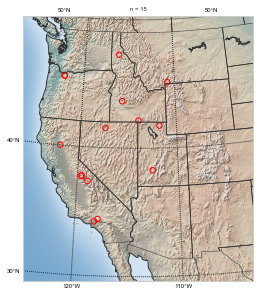

In [8]:
out = tools.plot_gagesmap(latlon["latgage"].as_matrix(), latlon["longage"].as_matrix())

## KS-Test for non-gamma distributed streamflow

stationid
10263500    0.011485
Name: meanCFS, dtype: float64


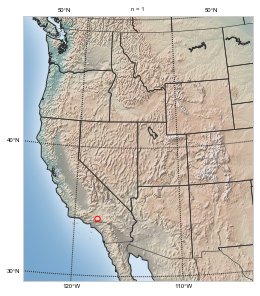

In [9]:
kspvals = raw.groupby(level = 'stationid')['meanCFS'].aggregate(tools.adj_gamma_kstest)
# latlon of gages which do not fit gamma.
print(kspvals[kspvals <= 0.05])
non_gamma = latlon[latlon['stationid'].isin(kspvals[kspvals <= 0.05].index.values)]
out = tools.plot_gagesmap(non_gamma["latgage"].as_matrix(), non_gamma["longage"].as_matrix())

## Test for peak runoff

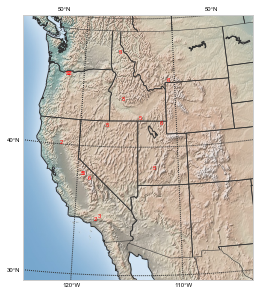

In [10]:
conn = sqlite3.connect(DB_PATH)
sql_query = """SELECT stationid, year, month, meanCFS FROM StationMonthly 
               WHERE year <= {cal_high} AND year >= {cal_low} AND stationid IN ({seq}) 
               ORDER BY stationid, year, month ASC""".format(cal_low = str(CAL_YEAR["low"]), 
                                                             cal_high = str(CAL_YEAR["high"]), 
                                                             seq = ",".join(["?"] * len(target_stations)))
monthly_flows = pd.read_sql(sql_query, conn, params = target_stations, index_col = ['stationid', 'year', 'month'])
conn.close()
monthly_mean = monthly_flows.groupby(level = ['stationid', 'month']).mean()
# Get month with max flow for each station.
max_month = monthly_mean.groupby(level = 'stationid').idxmax()['meanCFS'].apply(lambda a: a[1])

# Join max months with latlon data.
max_month = latlon.join(max_month, on = 'stationid')

# Plot data on map
fig = plt.figure(figsize = (4, 6))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
m = Basemap(width = 2000000, height = 2300000, 
            resolution = 'l', projection = 'stere', 
            lat_ts = 40.0, 
            lat_0 = 40.0, lon_0 = -114.0)
m.drawcoastlines(color = "#333333")
m.drawstates(linewidth = 0.7, color = "#333333")
m.drawcountries(color = "#333333")
m.shadedrelief()
parallels = np.arange(0., 81, 10)
m.drawparallels(parallels, labels = [True, False, True, False], color = "#333333")
meridians = np.arange(10., 351., 10)
m.drawmeridians(meridians, labels = [False, True, False, True], color = "#333333")
for r in max_month.iterrows():
    x, y = m(r[1]['longage'], r[1]['latgage'])  # A bit slow. Should do all at once.
    plt.text(x, y, r[1]['meanCFS'], color = 'r')
plt.show()

## Standardize streamflow

In [11]:
parsed = raw.groupby(level = "stationid")["meanCFS"].transform(tools.spigamma)
# parsed = raw.groupby(level = "stationid")["meanCFS"].transform(tools.zscore)

## Basic North Test scree plot

In [12]:
# Interesting iterations are:
# 1) standardized, correlation or covariance (`center = True` in this case).
# 2) Non-standardized correlation.
examine_modes = 10
solver = eofs.Eof(parsed.unstack().as_matrix(), center = False)
eof = solver.eofsAsCovariance(neofs = examine_modes)
pc = solver.pcs(npcs = examine_modes, pcscaling = 1)
frac_var = solver.varianceFraction(examine_modes)

In [13]:
# test = pd.DataFrame(pc)
# test.columns = ["PC" + str(x + 1) for x in range(examine_modes)]
# test['WY'] = WY_RANGE
# test.to_csv('pc_1925.csv', index = False)
pc = pd.DataFrame(pc,
                  columns = ['PC' + str(i + 1) for i in range(examine_modes)],
                  index = pd.Index(WY_RANGE, name = 'wy'))
pc.to_csv('pc_1925.csv', index = True)

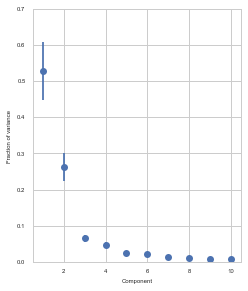

In [14]:
out = tools.plot_northtest(solver, nmodes = examine_modes)

In [15]:
retain_modes = 2

## PC time series from leading components

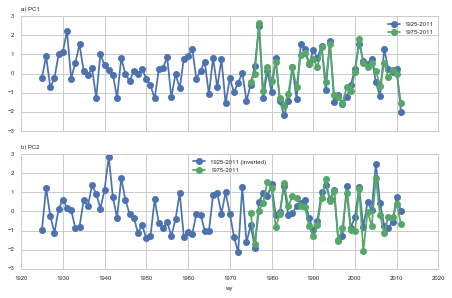

In [16]:
test_1975 = pd.read_csv('pc_1975.csv')
# test_1950 = pd.read_csv('pc_1950.csv')

fig, axes = plt.subplots(figsize = (7.48031, 4.52756), nrows = 2, ncols = 1, sharex = True, sharey = True)

axes.flat[0].plot(pc.reset_index()['wy'], pc['PC1'], '-o', label = '1925-2011')
# axes.flat[0].plot(test_1950['WY'], test_1950['PC1'], '-o', label = '1950-2011')
axes.flat[0].plot(test_1975['wy'], test_1975['PC1'], '-o', label = '1975-2011')
axes.flat[0].set_title('a) PC1', loc = 'left')
axes.flat[1].plot(pc.reset_index()['wy'], -pc['PC2'], '-o', label = '1925-2011 (inverted)')
# axes.flat[1].plot(test_1950['WY'], -test_1950['PC2'], '-o', label = '1950-2011 (inverted)')
axes.flat[1].plot(test_1975['wy'], test_1975['PC2'], '-o', label = '1975-2011')
axes.flat[1].set_title('b) PC2', loc = 'left')
axes.flat[0].legend()
axes.flat[1].legend(loc = 'upper center')
axes.flat[1].set_xlabel('wy')
axes.flat[0].xaxis.set_ticks(np.arange(1920, 2030, 10))
plt.savefig("./plots/s4.eps")

## Leading EOFs mapped as covariance

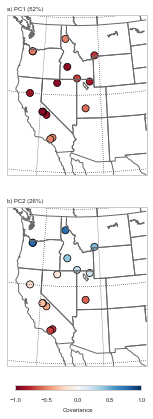

In [17]:
out = tools.plot_eof(solver, 
                     lat = latlon["latgage"].as_matrix(),
                     lon = latlon["longage"].as_matrix(), 
                     nmodes = retain_modes,
                     figure_size = (2.5, 6.5))
plt.savefig("./plots/s1.eps")

## Leading two modes as vectors

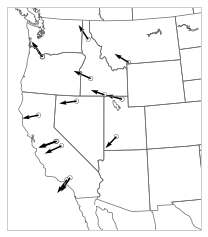

In [18]:
# Linear regression of the first two leading PCs onto the gage time series to get regression coefficients.
rcoef1 = parsed.groupby(level = "stationid").aggregate(lambda x: stats.linregress(pc.PC1, x)[0])
rcoef2 = parsed.groupby(level = "stationid").aggregate(lambda x: stats.linregress(pc.PC2, x)[0])

out = tools.plot_vectormap(coef1 = rcoef1, coef2 = rcoef2,
                           lat = latlon["latgage"].as_matrix(),
                           lon = latlon["longage"].as_matrix())

# Point correlation maps

In [19]:
def pointfield_corr(**kwargs):
    """ Point correlation with significance test"""
    out = tools.pointfield_statistic(**kwargs, 
                                     stat_fun = tools.pearson_corr,
                                     stat_name = 'Correlation')
    return out

def plot_pointfield_corr(ds, map_type):
    """Plot point correlation maps"""
    out = tools.plot_pointfield_statistic(ds = ds,
                                          map_type = map_type,
                                          stat_name = 'Correlation',
                                          plotfun = 'contourf',
                                          levels = np.arange(-1, 1.1, 0.1))
    return out

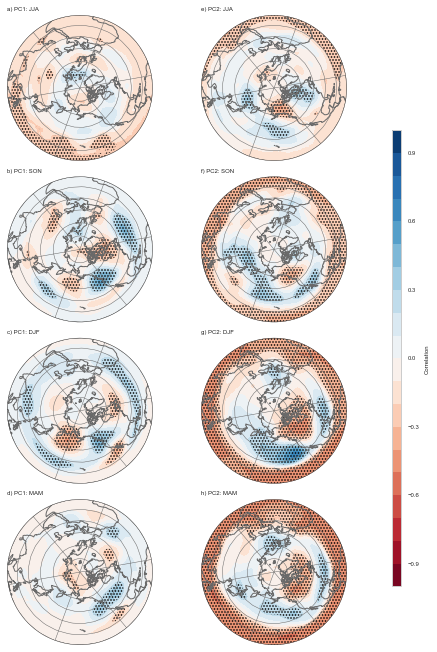

In [20]:
with xr.open_dataset(TCR_PATH) as hgt:
    hgt_anom = (hgt.sel(wy = slice(pd.to_datetime(WATER_YEAR['low'], format = '%Y'), 
                                   pd.to_datetime(WATER_YEAR['high'], format = '%Y')))
                   .z500
                   .groupby('season')
                   .apply(lambda x: x - x.mean(dim = 'wy'))
                   .copy())

hgt_corrs = pointfield_corr(field = hgt_anom, pc_df = pc)
out = plot_pointfield_corr(hgt_corrs, map_type = 'north_hemisphere')
plt.savefig("./plots/s5.eps")

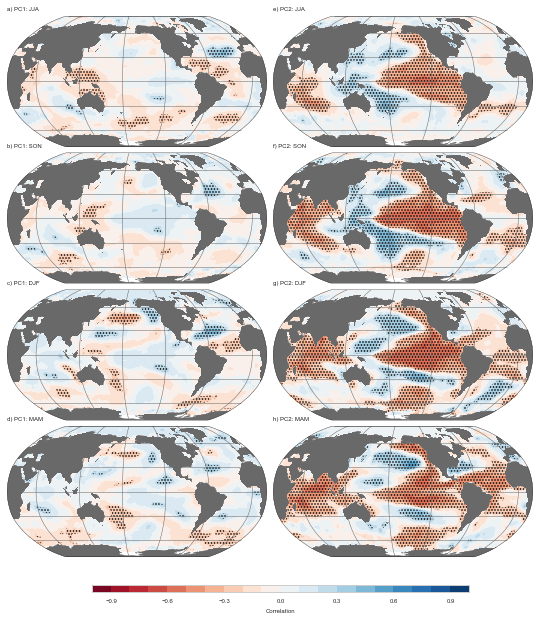

In [21]:
with xr.open_dataset(ERSST_PATH) as field:
    sst_anom = (field.sel(wy = slice(pd.to_datetime(WATER_YEAR['low'], format = '%Y'), 
                                       pd.to_datetime(WATER_YEAR['high'], format = '%Y')))
                     .sst
                     .groupby('season')
                     .apply(lambda x: x - x.mean(dim = 'wy'))
                     .copy())

sst_corrs = pointfield_corr(field = sst_anom, pc_df = pc)
out = plot_pointfield_corr(sst_corrs, map_type = 'global')
plt.savefig("./plots/s6.eps")

# Composite maps

In [22]:
def pointfield_ttest(**kwargs):
    """ Point correlation with significance test"""
    out = tools.pointfield_statistic(**kwargs, 
                                     stat_fun = tools.composite_ttest)
    return out

def plot_pointfield_ttest(ds, map_type, **kwargs):
    """Plot composite t-test maps"""
    out = tools.plot_pointfield_statistic(ds = ds,
                                          map_type = map_type,
                                          plotfun = 'pcolormesh',
                                          **kwargs)
    return out

<xarray.DataArray 'Composite difference (m)' ()>
array(-42.228703665226064)
<xarray.DataArray 'Composite difference (m)' ()>
array(56.30159860164561)


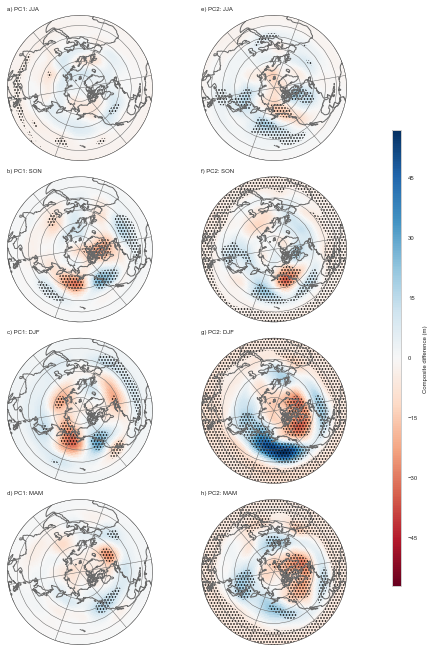

In [23]:
with xr.open_dataset(TCR_PATH) as hgt:
    hgt_anom = (hgt.sel(wy = slice(pd.to_datetime(WATER_YEAR['low'], format = '%Y'), 
                                   pd.to_datetime(WATER_YEAR['high'], format = '%Y')))
                   .z500
                   .groupby('season')
                   .apply(lambda x: x - x.mean(dim = 'wy'))
                   .copy())
    
stat_str = 'Composite difference (m)'
hgt_ttest = pointfield_ttest(stat_name = stat_str,
                             field = hgt_anom, 
                             pc_df = pc)

out = plot_pointfield_ttest(hgt_ttest, 
                            map_type = 'north_hemisphere', 
                            stat_name = stat_str,
                            vmin = -57, vmax = 57)
plt.savefig("./plots/s7.eps")

print(hgt_ttest[stat_str].min())
print(hgt_ttest[stat_str].max())

<xarray.DataArray 'Composite difference (°C)' ()>
array(-1.4825115568816982)
<xarray.DataArray 'Composite difference (°C)' ()>
array(0.7363527086186916)


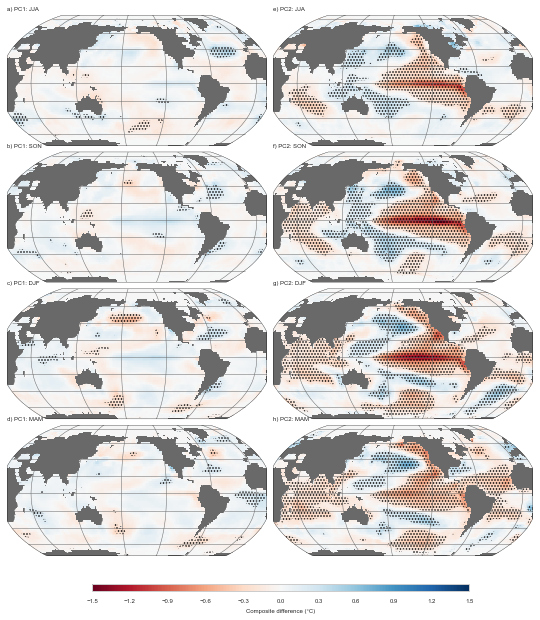

In [24]:
# Now lets see if we can speed things up for all season correlations with xarray.

with xr.open_dataset(ERSST_PATH) as field:
    sst_anom = (field.sel(wy = slice(pd.to_datetime(WATER_YEAR['low'], format = '%Y'), 
                                       pd.to_datetime(WATER_YEAR['high'], format = '%Y')))
                     .sst
                     .groupby('season')
                     .apply(lambda x: x - x.mean(dim = 'wy'))
                     .copy())

stat_str = 'Composite difference (°C)'
sst_ttest = pointfield_ttest(stat_name = stat_str,
                             field = sst_anom, 
                             pc_df = pc)
out = plot_pointfield_ttest(sst_ttest, 
                            map_type = 'global', 
                            stat_name = stat_str,
                            vmin = -1.5, vmax = 1.5)
plt.savefig("./plots/s8.eps")

print(sst_ttest[stat_str].min())
print(sst_ttest[stat_str].max())